In [1]:
import torch as th
import torchvision.transforms as T
import requests
from PIL import Image, ImageDraw, ImageFont

In [2]:
model = th.hub.load('facebookresearch/detr', 'detr_resnet101', pretrained=True)
model.eval()
model = model.cuda()

Downloading: "https://github.com/facebookresearch/detr/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth" to /root/.cache/torch/hub/checkpoints/detr-r101-2c7b67e5.pth


  0%|          | 0.00/232M [00:00<?, ?B/s]

In [3]:
# standard PyTorch mean-std input image normalization
transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

In [12]:
url = input()

https://reviewed-com-res.cloudinary.com/image/fetch/s--bEJHoBnA--/b_white,c_limit,cs_srgb,f_auto,fl_progressive.strip_profile,g_center,q_auto,w_1200/https://reviewed-production.s3.amazonaws.com/1626715056499/checkedhero.jpg


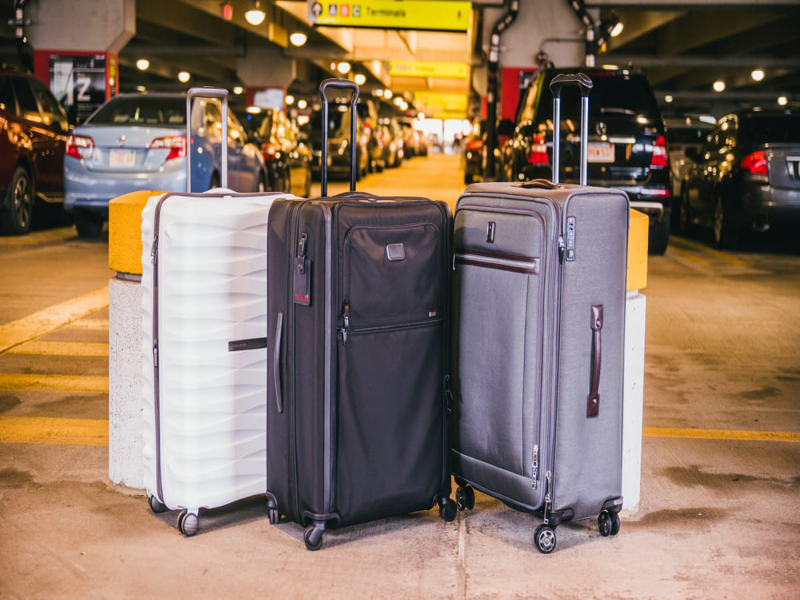

In [13]:
img = Image.open(requests.get(url, stream=True).raw).resize((800,600)).convert('RGB')
img

In [14]:
img_tens = transform(img).unsqueeze(0).cuda()

In [15]:
with th.no_grad():
  output = model(img_tens)

In [16]:
im2 = img.copy()
drw = ImageDraw.Draw(im2)
pred_logits=output['pred_logits'][0][:, :len(CLASSES)]
pred_boxes=output['pred_boxes'][0]

max_output = pred_logits.softmax(-1).max(-1)
topk = max_output.values.topk(15)

pred_logits = pred_logits[topk.indices]
pred_boxes = pred_boxes[topk.indices]
pred_logits.shape

torch.Size([15, 91])

In [17]:

for logits, box in zip(pred_logits, pred_boxes):
  cls = logits.argmax()
  if cls >= len(CLASSES):
    continue
  label = CLASSES[cls]
  print(label)
  box = box.cpu() * th.Tensor([800, 600, 800, 600])
  x, y, w, h = box
  x0, x1 = x-w//2, x+w//2
  y0, y1 = y-h//2, y+h//2
  drw.rectangle([x0, y0, x1, y1], outline='red', width=5)
  drw.text((x, y), label, fill='white')

car
suitcase
suitcase
car
car
car
car
suitcase
car
car
car
person
truck
car
car


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  # Remove the CWD from sys.path while we load stuff.


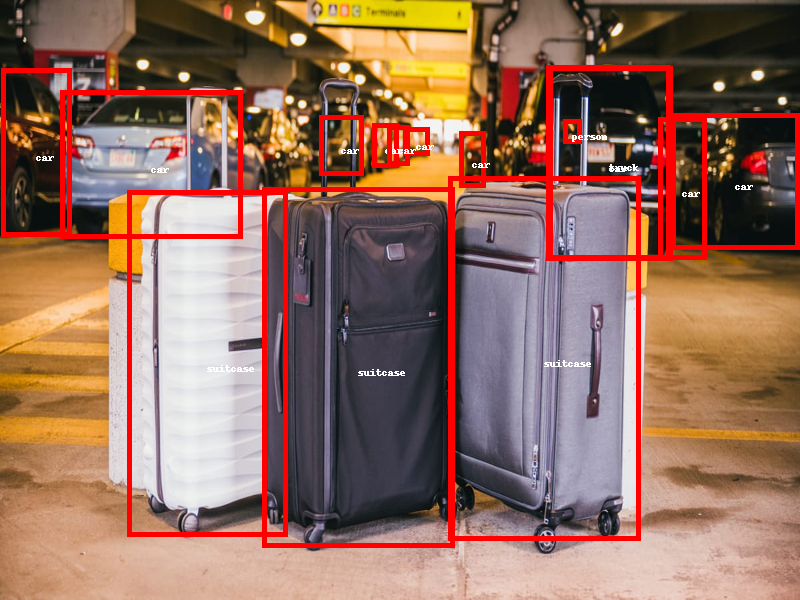

In [18]:
im2